In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import re
import datetime

from sklearn.impute import SimpleImputer


%matplotlib inline


In [2]:
df = pd.read_csv('../Data/amazon_clean_0512.csv', index_col=0)
df.head(2)

,name,price_current,price_original,reviews_number,seller,score,brand,Series,Color,height_cm,...,Tipo de conexión inalámbrica,usb_2,usb_3,Tipo de unidad óptica,os,battery_wh,battery_cells,weight_kg,Número de modelo del producto,since
0,"Huawei MateBook D 15"" - AMD Ryzen, Windows 10-...",14999.0,NaN,156.0,Huawei,4.7,Huawei,Matebook D 15,Gris,0.17,...,Bluetooth,2.0,1.0,None,Windows 10 Home,42.0,2.0,2.3,6901443370764,2020-02-20
1,"Asus Laptop VivoBook 15.6"", Core i7, 8GB RAM,...",17999.0,19999.0,NaN,Asus,NaN,Asus,X512FA-BR1412T,NaN,NaN,...,NaN,2.0,2.0,Ninguno,Windows 10,1000.0,1.0,2.5,NaN,2020-03-10


## Droping unuseful column to this case

In [3]:
df = df.drop(columns=[
    'Tecnología de la memoria', 
    'Tipo de unidad óptica', 
    'Tipo de conexión inalámbrica', 
    'Número de modelo del producto',
    'usb_3',
    'usb_2',
    'Series',
    'Color',
    'Descripción del disco duro',
    'Tipo de RAM para gráficos',
    'memory_interface',
    'gpu_interface',
    'resolution_x',
    'resolution_y',
    'gpu_ram',
    'Descripción de la tarjeta gráfica',
    'Coprocesador de gráficos',
    'Tipo de procesador'
    ])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 0 to 511
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            512 non-null    object 
 1   price_current   220 non-null    float64
 2   price_original  41 non-null     float64
 3   reviews_number  469 non-null    float64
 4   seller          512 non-null    object 
 5   score           469 non-null    float64
 6   brand           512 non-null    object 
 7   height_cm       469 non-null    float64
 8   width_cm        468 non-null    float64
 9   screen_size_in  509 non-null    float64
 10  proc_brand      488 non-null    object 
 11  proc_speed_ghz  448 non-null    float64
 12  ram             506 non-null    float64
 13  ram_type        368 non-null    object 
 14  ram_max         342 non-null    float64
 15  memory          429 non-null    float64
 16  os              496 non-null    object 
 17  battery_wh      508 non-null    flo

## Converting dtypes

In [5]:
df = df.convert_dtypes()


In [6]:
df.brand = df.brand.str.lower()
df.brand = df.brand.astype('category')

In [7]:
df.seller = df.seller.str.lower()
df.seller = df.seller.astype('category')


In [8]:
df.proc_brand = df.proc_brand.astype('category')


In [9]:
df.os = df.os.astype('category')


In [10]:
# df.screen_size_in = df.screen_size_in.astype('category')

In [11]:
df.ram_type = df.ram_type.astype('category')

In [12]:
# df.ram = df.ram.astype('category')

In [13]:
df.since = pd.to_datetime(df.since)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 0 to 511
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            512 non-null    string        
 1   price_current   220 non-null    float64       
 2   price_original  41 non-null     float64       
 3   reviews_number  469 non-null    Int64         
 4   seller          512 non-null    category      
 5   score           469 non-null    float64       
 6   brand           512 non-null    category      
 7   height_cm       469 non-null    float64       
 8   width_cm        468 non-null    float64       
 9   screen_size_in  509 non-null    Int64         
 10  proc_brand      488 non-null    category      
 11  proc_speed_ghz  448 non-null    float64       
 12  ram             506 non-null    Int64         
 13  ram_type        368 non-null    category      
 14  ram_max         342 non-null    Int64         
 15  memory

In [15]:
df.describe()

,price_current,price_original,reviews_number,score,height_cm,width_cm,screen_size_in,proc_speed_ghz,ram,ram_max,memory,battery_wh,battery_cells,weight_kg
count,220.000000,41.000000,469.000000,469.000000,469.000000,468.000000,509.000000,448.000000,506.000000,342.000000,429.000000,5.080000e+02,491.000000,512.000000
mean,24738.809727,25876.765366,165.200426,3.952665,4.522495,24.488654,15.007859,9.980089,11.845850,31.301170,374.284382,1.976488e+04,3.179226,4.599219
std,19197.740655,16406.351173,440.464016,0.664112,9.792554,10.732078,1.602145,120.890180,28.809239,91.548874,394.249285,4.436748e+05,2.625708,36.170971
min,3783.700000,9239.000000,1.000000,1.000000,0.070000,0.080000,7.000000,0.800000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000
25%,12499.000000,13999.000000,6.000000,3.600000,0.180000,22.575000,14.000000,1.750000,4.000000,8.000000,32.000000,3.175000e+01,2.000000,2.200000
50%,19894.500000,21499.010000,28.000000,4.000000,0.220000,25.450000,16.000000,2.300000,8.000000,16.000000,256.000000,4.200000e+01,3.000000,2.600000
75%,28810.000000,31188.000000,109.000000,4.300000,0.280000,30.500000,16.000000,2.825000,12.000000,32.000000,512.000000,5.100000e+01,4.000000,3.425000
max,152650.000000,71598.680000,4382.000000,5.000000,47.700000,57.400000,18.000000,2400.000000,512.000000,1024.000000,2048.000000,1.000000e+07,45.000000,821.000000


In [16]:
df.describe(include='category')

,seller,brand,proc_brand,ram_type,os
count,512,512,488,368,496
unique,32,32,16,11,26
top,asus,asus,Intel,DDR4,Windows 10
freq,108,108,388,211,252


## Working with NAs and duplicates

#### Features to simplify the management of NaNs

In [17]:
def most_common(column):
    return column.value_counts().first_valid_index()

In [18]:
def repl_na(column, default = True, value = -1):
    if default:
        if column.dtype == 'Int64' or column.dtype == 'float64':
            column.fillna(column.median(), inplace=True)

        elif column.dtype == 'category':
            column.fillna(most_common(column), inplace=True)
    else:
        column.fillna(value, inplace=True)

#### Filling some fields with customs values

In [19]:
repl_na(df.reviews_number, False, 0)

In [20]:
repl_na(df.score, False, 0)


In [21]:
repl_na(df.price_current, False, df.price_current.median())

In [22]:
repl_na(df.price_original, False, df.price_current)

In [23]:
repl_na(df.height_cm, False , df.height_cm.mean())

In [24]:
repl_na(df.width_cm, False, df.width_cm.mean())

#### The remaining columns with NaNs will be replaced by the most common value for categoricals and by the median for numericals

In [25]:
df.columns[df.isna().any()]

Index(['screen_size_in', 'proc_brand', 'proc_speed_ghz', 'ram', 'ram_type',
       'ram_max', 'memory', 'os', 'battery_wh', 'battery_cells'],
      dtype='object')

In [26]:
for column in df.columns[df.isna().any()]:
    repl_na(df[column])


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 0 to 511
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            512 non-null    string        
 1   price_current   512 non-null    float64       
 2   price_original  512 non-null    float64       
 3   reviews_number  512 non-null    Int64         
 4   seller          512 non-null    category      
 5   score           512 non-null    float64       
 6   brand           512 non-null    category      
 7   height_cm       512 non-null    float64       
 8   width_cm        512 non-null    float64       
 9   screen_size_in  512 non-null    Int64         
 10  proc_brand      512 non-null    category      
 11  proc_speed_ghz  512 non-null    float64       
 12  ram             512 non-null    Int64         
 13  ram_type        512 non-null    category      
 14  ram_max         512 non-null    Int64         
 15  memory

In [28]:
df.describe()

,price_current,price_original,reviews_number,score,height_cm,width_cm,screen_size_in,proc_speed_ghz,ram,ram_max,memory,battery_wh,battery_cells,weight_kg
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,5.120000e+02,512.000000,512.000000
mean,21976.039336,22329.815391,151.326172,3.620703,4.522495,24.488654,15.013672,9.020078,11.800781,26.220703,355.109375,1.961079e+04,3.171875,4.599219
std,12795.056097,13085.488559,424.012527,1.268156,9.371486,10.259632,1.599232,113.095182,28.642601,75.132942,363.442246,4.419383e+05,2.571435,36.170971
min,3783.700000,3783.700000,0.000000,0.000000,0.070000,0.080000,7.000000,0.800000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000
25%,19894.500000,19894.500000,4.000000,3.475000,0.180000,22.600000,14.000000,1.800000,4.000000,8.000000,64.000000,3.200000e+01,2.000000,2.200000
50%,19894.500000,19894.500000,22.000000,4.000000,0.230000,25.100000,16.000000,2.300000,8.000000,16.000000,256.000000,4.200000e+01,3.000000,2.600000
75%,19894.500000,19894.500000,92.000000,4.300000,4.522495,29.200000,16.000000,2.700000,12.000000,16.000000,512.000000,5.100000e+01,4.000000,3.425000
max,152650.000000,152650.000000,4382.000000,5.000000,47.700000,57.400000,18.000000,2400.000000,512.000000,1024.000000,2048.000000,1.000000e+07,45.000000,821.000000


In [29]:
df.describe(include='category')

,seller,brand,proc_brand,ram_type,os
count,512,512,512,512,512
unique,32,32,16,11,26
top,asus,asus,Intel,DDR4,Windows 10
freq,108,108,412,355,268


## Detecting and managing outliers

#### Configuration for BoxPlots

In [30]:
def boxplot_config(ax, x, labels=None, title='', xlabel='', ylabel=''):
    # Personalization of siymbols and lines
    boxprops = dict(linestyle='--', linewidth=2, color='darkgoldenrod')
    flierprops = dict(marker='o', markerfacecolor='green', markersize=6, label='outlier')
    medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick', label='median')
    meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='skyblue', label='mean')

    bbplot = ax.boxplot(x,
                    patch_artist=True,  # enable fill with color
                    labels=labels,
                    showmeans = True,
                    boxprops=boxprops,
                    flierprops=flierprops,
                    medianprops=medianprops,
                    meanprops=meanpointprops
                    )

    # Assigning color for each box
    box_number = len( bbplot['boxes'] )

    color_fracs = np.array(list( range( box_number )) ) / box_number

    color_norm = matplotlib.colors.Normalize(color_fracs.min(), color_fracs.max())
    color_norm

    for frac, patch in zip(color_fracs, bbplot['boxes']):
        color = plt.cm.summer(color_norm(frac))
        patch.set_facecolor(color)

    # Adding labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()


In [55]:
df.select_dtypes(include = 'number').columns

Index(['price_current', 'price_original', 'reviews_number', 'score',
       'height_cm', 'width_cm', 'screen_size_in', 'proc_speed_ghz', 'ram',
       'ram_max', 'memory', 'battery_wh', 'battery_cells', 'weight_kg'],
      dtype='object')

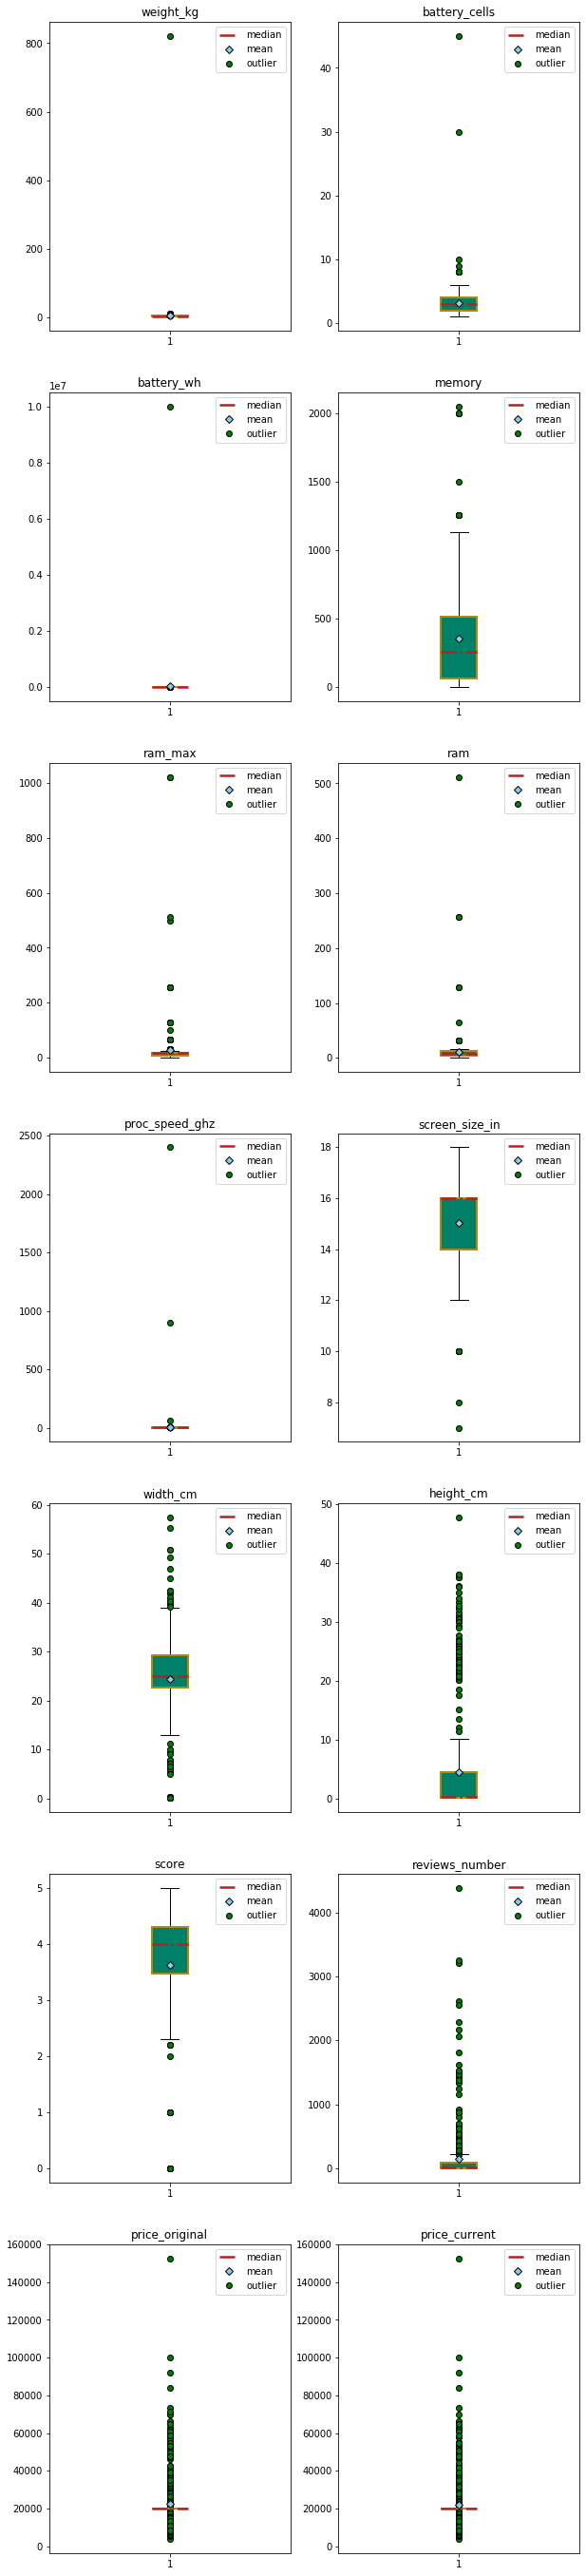

In [121]:
columns = df.select_dtypes(include = 'number').columns
columns_number = len(columns)

plot_cols = 2
plot_rows = int(columns_number / plot_cols)
plot_size_y = int(round( plot_rows * 7, 0 ))
plot_size_x = int(round( plot_cols * 5, 0 ))

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(plot_size_x, plot_size_y))

for nrow in range(0, plot_rows):
    for ncol in range(0, plot_cols):
        columns_number -= 1
        boxplot_config(ax[nrow][ncol], df[columns[columns_number]], title=columns[columns_number])

## Showing filtered data and exporting processed data


df_time = df.set_index(df.since).copy()
df_time.head(2)

df_time.resample('Y').median()

df.to_csv('../Data/amazon_filtered_' + datetime.datetime.today().strftime('%m%d') + '.csv')